In [181]:
from pathlib import Path 
import pandas as pd
import matplotlib.pyplot as plt

In [183]:
def load_data(file_path):
    df = pd.read_excel(file_path)
    return df

In [185]:
def compute_total_nights(df):
    df = df.copy()
    df["total_nights"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]
    return df

In [187]:
def compute_total_price(df):
    df = df.copy()
    df["total_price"] = (df["adr"] * df["total_nights"]).round(2)
    return df

In [189]:
def add_tertile_bands(df):
    df = df.copy()
    df["price_band_tertiles"] = pd.qcut(
        df["total_price"], q=3, labels=["Low", "Medium", "High"]
    ).astype("category")
    return df

Low / Medium / High groups with roughly equal counts based on total_price.
Balanced sample sizes, which makes model training and between-group comparisons easier and helps avoid “empty bins” caused by extreme values.
Business relevance: Balanced cohorts to compare KPIs (e.g., cancel rate, upsell take-rate) across price tiers.

In [192]:
def add_equalwidth_bands(df , bins: int = 3):
    df = df.copy()
    df["price_band_equalwidth"] = pd.cut(
        df["total_price"], bins=bins, labels=["Low", "Medium", "High"], include_lowest=True
    ).astype("category")
    return df

Low / Medium / High bands split by equal price ranges between min and max.
Stable, easy-to-interpret thresholds (e.g., “0–200, 200–400, 400+”), which is convenient for pricing policies and dashboard presentation.
Business relevance: Clear price ladders for marketing and yield dashboards; good for rule-based actions (e.g., stricter deposit for High band).

In [195]:
def save_enriched_data(df, output_path):
    df.to_csv(output_path, index=False)

In [216]:
def run_summary_and_plot(df):
    # Descriptive snapshot
    view = df[["adr", "total_nights", "total_price"]]
    print("=== Shape ===")
    print(df.shape)

    print("\n=== Describe (adr, total_nights, total_price) ===")
    print(view.describe(percentiles=[0.25, 0.5, 0.75]).round(2))
    
    print("Tertile thresholds:")
    print(df["total_price"].quantile([0, 1/3, 2/3, 1]).round(2))
    print("\n=== Counts by tertiles ===")
    print(df["price_band_tertiles"].value_counts(sort=False))

    print("\n=== Counts by equal-width ===")
    print(df["price_band_equalwidth"].value_counts(sort=False))

    # cancellation rate by price band
    print("\n=== Cancel rate by tertiles ===")
    print(df.groupby("price_band_tertiles", observed=True)["is_canceled"].mean().round(3))
    print("\n=== Cancel rate by equal-width ===")
    print(df.groupby("price_band_equalwidth", observed=True)["is_canceled"].mean().round(3))

    p99 = df["total_price"].quantile(0.99)
    subset = df.loc[df["total_price"] <= p99, "total_price"]

    q = df["total_price"].quantile([1/3, 2/3])  # tertile edges

    plt.figure()
    subset.plot(kind="hist", bins=30)
    for x in q:
       plt.axvline(x, linestyle="--")  # show tertile cut points
    plt.title("Total Price Distribution (≤ P99) with Tertile Cutlines")
    plt.ylabel("Frequency")
    plt.show()

In [218]:
def main(input_file, output_file, bins):
    df = load_data(input_file)
    df = compute_total_nights(df)
    df = compute_total_price(df)
    df = add_tertile_bands(df)
    df = add_equalwidth_bands(df, bins=bins)

    save_enriched_data(df, output_file)
    print(f"\nSaved → {Path(output_file).resolve()}")

    return df  


Saved → /Users/xiafeier/hotel_bookings_enriched.csv
=== Shape ===
(87396, 36)

=== Describe (adr, total_nights, total_price) ===
            adr  total_nights  total_price
count  87396.00      87396.00     87396.00
mean     106.34          3.63       394.31
std       55.01          2.76       369.45
min        0.00          0.00         0.00
25%       72.00          2.00       152.48
50%       98.10          3.00       299.00
75%      134.00          5.00       503.20
max     5400.00         69.00      7590.00
Tertile thresholds:
0.000000       0.0
0.333333     199.0
0.666667     416.7
1.000000    7590.0
Name: total_price, dtype: float64

=== Counts by tertiles ===
price_band_tertiles
Low       29145
Medium    29120
High      29131
Name: count, dtype: int64

=== Counts by equal-width ===
price_band_equalwidth
Low       87211
Medium      180
High          5
Name: count, dtype: int64

=== Cancel rate by tertiles ===
price_band_tertiles
Low       0.192
Medium    0.284
High      0.348
Nam

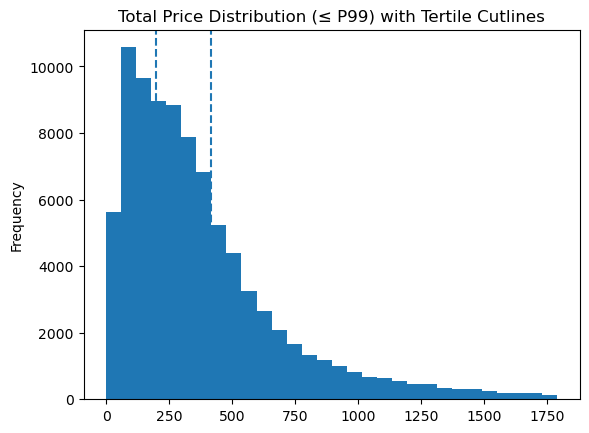

In [222]:
if __name__ == "__main__":
    input_path = "/Users/xiafeier/Desktop/PODA/hotel_bookings_cleaned.xlsx"
    output_path = "hotel_bookings_enriched.csv"
    
    final_data = main(input_path, output_path,3)
    run_summary_and_plot(final_data)

The script loads a cleaned Excel file, then builds three features in sequence. First, compute_total_nights adds weekday and weekend nights to get stay length per booking. Next, compute_total_price multiplies ADR by total nights and rounds to two decimals, yielding booking-level room revenue. Then two price bands are created: add_tertile_bands uses equal-frequency tertiles (Low/Medium/High), while add_equalwidth_bands splits the min–max range into three fixed intervals. The dataset is saved, and run_summary_and_plot prints quick checks and draws a histogram of total_price with tertile cutlines, zoomed to P99 so the long tail doesn’t dominate.

Shape: 87,396 rows × 36 columns.

Descriptive stats: adr mean ≈ 106.34, total_nights mean ≈ 3.63, and total_price mean ≈ 394.31; max total_price hits 7,590, confirming a long right tail.

Tertile thresholds: about ≈199.60 and ≈416.70; tertile counts are roughly balanced (~29k each), which is ideal for fair KPI comparisons.

Equal-width counts: Low 87,211, Medium 180, High 5; extreme values stretch the upper bound, so most bookings fall into “Low.”

Cancel rate by tertiles: Low 0.192, Medium 0.284, High 0.348 (0–1 scale). Cancellation rises with price in these data.

Cancel rate by equal-width: Low 0.274, Medium 0.617, High 0.600; but “Medium/High” have tiny samples (180/5), so these rates are unstable.

The histogram of total_price (capped at P99) is strongly right-skewed: many lower-value bookings with a long, thin high-value tail. The dashed tertile lines near ~200 and ~417 show where Low/Medium/High split, visually confirming balanced tertile coverage across the main mass of bookings.